# Modelos

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from dython.nominal import theils_u, correlation_ratio
import numpy as np
from tqdm.notebook import trange, tqdm

In [6]:
df = pd.read_csv('data/MICRODADOS_ENEM_SP_2019.csv', low_memory = False)
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,...,Q024,Q025,NO_MUNICIPIO_ESC_LON,NO_MUNICIPIO_ESC_LAT,NO_MUNICIPIO_NASCIMENTO_LON,NO_MUNICIPIO_NASCIMENTO_LAT,NO_MUNICIPIO_PROVA_LON,NO_MUNICIPIO_PROVA_LAT,NO_MUNICIPIO_RESIDENCIA_LON,NO_MUNICIPIO_RESIDENCIA_LAT
0,190001017053,2019,3546801,Santa Isabel,35,SP,22,M,1,3,...,B,B,NaN,NaN,-48.160553,-1.296856,-48.160553,-1.296856,-46.22719,-23.319422
1,190003671803,2019,3546801,Santa Isabel,35,SP,15,M,1,2,...,B,A,NaN,NaN,-46.633382,-23.550651,-46.633382,-23.550651,-46.22719,-23.319422
2,190005877964,2019,3546801,Santa Isabel,35,SP,19,M,1,3,...,B,B,NaN,NaN,-46.633382,-23.550651,-46.633382,-23.550651,-46.22719,-23.319422
3,190005853729,2019,3546801,Santa Isabel,35,SP,22,F,1,2,...,A,B,NaN,NaN,-47.184632,-23.540125,-46.633382,-23.550651,-46.22719,-23.319422
4,190004762110,2019,3546801,Santa Isabel,35,SP,20,M,1,2,...,B,B,NaN,NaN,-46.227190,-23.319422,-46.633382,-23.550651,-46.22719,-23.319422


## Variáveis utilizadas

Inicialmente iremos fazer uma limpeza dos dados para mantér apenas aqueles que são úteis nos modelos, as etapas de limpeza serão:

- Remover linhas de participantes que estiveram ausentes em algum dos dois dias de provas, não é interessante modelar esses cenários pois já é possível afirmar que participantes que se ausentaram em determinado dia obterão nota 0. E removemos as colunas que indicam presença (dados restantes só possuem participantes presentes).

- Criamos a coluna 'NOTA' com a nota média. E removemos as colunas com as notas individuais em cada uma das provas.

- Removemos colunas que sabemos que não possuem relação com o resultado nas provas: númeo de inscrição; ano da prova; código da escola; se optou por nome social; se optou por cadeira para canhoto;

- Removemos colunas que possuem informações espaciais pois não usaremos elas nos modelos. As variáveis podem assumir muitos valores nominais distintos, gerando dados que não obterão bons resultados nos modelos.

- As variáveis que indicam deficiência foram agrupadas em uma única variável que indica se o particpante possui alguma defiência ou não. As colunas que indicam a deficiência específica foram removidas.

- As variáveis que indicam necessidade de atendimento especial também foram agrupadas em uma única variável. As demais foram removidas.

- Removemos as variáveis sobre algumas perguntas socioeconômicas: profissão do pai; profissão da mãe.

- Alteramos as respostas de colunas que indicam a quantidade de eletrodomésticos que o participante possui em casa.

- Nas colunas sobre dados das escolas, pela grande presença de valores ausentes, adicionamos uma nova categoria que indica se o valor é ausente.


In [7]:
#keeping only the rows where the student went to the test
df = df[(df.TP_PRESENCA_CN == 1) & (df.TP_PRESENCA_CH == 1) &
       (df.TP_PRESENCA_LC == 1) & (df.TP_PRESENCA_MT == 1)]
#removing presence columns
df = df.drop(columns = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'])
#creating NU_NOTA column
df['NOTA'] = 0.2 * (df.NU_NOTA_CN + df.NU_NOTA_CH + df.NU_NOTA_MT + df.NU_NOTA_LC + df.NU_NOTA_REDACAO)
#removing other notes columns
df = df.drop(columns = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_LC',
                        'NU_NOTA_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 
                        'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'TP_STATUS_REDACAO'])
#removing columns that don't have relation with the result in the test
df = df.drop(columns = ['NU_INSCRICAO', 'NU_ANO', 'CO_ESCOLA', 'IN_NOME_SOCIAL', 'IN_CADEIRA_CANHOTO', 'TP_ANO_CONCLUIU'])
#removing columns with loction information
df = df.drop(columns = ['CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA',
                       'SG_UF_RESIDENCIA', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO', 
                       'NO_MUNICIPIO_ESC', 'SG_UF_ESC', 'CO_MUNICIPIO_PROVA',  'NO_MUNICIPIO_PROVA',
                       'CO_UF_PROVA', 'SG_UF_PROVA', 'NO_MUNICIPIO_ESC_LON', 'NO_MUNICIPIO_ESC_LAT',
                       'NO_MUNICIPIO_NASCIMENTO_LON', 'NO_MUNICIPIO_NASCIMENTO_LAT', 'NO_MUNICIPIO_PROVA_LON',
                       'NO_MUNICIPIO_PROVA_LAT', 'NO_MUNICIPIO_RESIDENCIA_LON', 'NO_MUNICIPIO_RESIDENCIA_LAT'])
#unifying columns
df['DEFICIENCIA'] = (df.IN_BAIXA_VISAO | df.IN_CEGUEIRA | df.IN_SURDEZ | df.IN_DEFICIENCIA_AUDITIVA | 
                    df.IN_SURDO_CEGUEIRA | df.IN_DEFICIENCIA_FISICA | df.IN_DEFICIENCIA_MENTAL | 
                    df.IN_DEFICIT_ATENCAO | df.IN_DISLEXIA | df.IN_DISCALCULIA | df.IN_AUTISMO |
                    df.IN_VISAO_MONOCULAR | df.IN_OUTRA_DEF)
#removing individual columns
df = df.drop(columns = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
                       'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO',
                       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF'])

#uniying columns
df['ATENDIMENTO_ESPECIAL'] = (df.IN_GESTANTE | df.IN_LACTANTE | df.IN_IDOSO | df.IN_ESTUDA_CLASSE_HOSPITALAR |
                             df.IN_BRAILLE | df.IN_AMPLIADA_24 | df.IN_AMPLIADA_18 | df.IN_LEDOR | df.IN_ACESSO | 
                             df.IN_TRANSCRICAO | df.IN_LIBRAS | df.IN_TEMPO_ADICIONAL | df.IN_LEITURA_LABIAL |
                             df.IN_MESA_CADEIRA_RODAS | df.IN_MESA_CADEIRA_SEPARADA | df.IN_APOIO_PERNA |
                             df.IN_GUIA_INTERPRETE | df.IN_COMPUTADOR | df.IN_CADEIRA_ESPECIAL | df.IN_CADEIRA_ACOLCHOADA |
                             df.IN_PROVA_DEITADO | df.IN_MOBILIARIO_OBESO | df.IN_LAMINA_OVERLAY | df.IN_PROTETOR_AURICULAR |
                             df.IN_MEDIDOR_GLICOSE | df.IN_MAQUINA_BRAILE | df.IN_SOROBAN | df.IN_MARCA_PASSO |
                             df.IN_SONDA | df.IN_MEDICAMENTOS | df.IN_SALA_INDIVIDUAL | df.IN_SALA_ESPECIAL |
                             df.IN_SALA_ACOMPANHANTE | df.IN_MOBILIARIO_ESPECIFICO | df.IN_MATERIAL_ESPECIFICO) 
#removing individual columns
df = df.drop(columns = ['IN_TREINEIRO', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 
                        'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 
                        'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 
                        'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 
                        'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 
                        'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 
                        'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL', 
                        'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO'])

df = df.drop(columns = ['Q003', 'Q004', ])
#renaming columns
def rename_cols(col):
    if col[:2] == 'NU' or col[:2] == 'TP':
        return col[3:]
    elif col[0] == 'Q':
        questions_dict = {'Q001': 'ESTUDO_PAI', 'Q002': 'ESTUDO_MAE', 'Q005': 'PESSOAS_RESIDENCIA', 
                         'Q006': 'RENDA', 'Q007':'EMPREGADO_DOMESTICO', 'Q008':'BANHEIRO', 'Q009':'QUARTOS',
                         'Q010': 'CARRO', 'Q011': 'MOTO', 'Q012': 'GELADEIRA', 'Q013': 'FREEZER',
                         'Q014': 'MAQUINA_LAVAR', 'Q015':'MAQUINA_SECAR', 'Q016':'MICRO_ONDAS',
                         'Q017':'LAVAR_LOUCA', 'Q018':'ASPIRADOR_PO', 'Q019':'TV', 'Q020': 'DVD',
                         'Q021': 'TV_ASSINATURA', 'Q022': 'CELULAR', 'Q023': 'TELEFONE', 'Q024': 'COMPUTADOR',
                         'Q025': 'INTERNET'}
        return questions_dict[col]
    else:
        return col
        
df = df.rename(columns = rename_cols)

#changing values for columns
df.EMPREGADO_DOMESTICO = df.EMPREGADO_DOMESTICO.map({'A': 0., 'B':1., 'C': 3., 'D':5.})
for col in ['BANHEIRO', 'QUARTOS', 'CARRO', 'MOTO', 'GELADEIRA', 'FREEZER',
           'MAQUINA_LAVAR', 'MAQUINA_SECAR', 'MICRO_ONDAS', 'LAVAR_LOUCA', 
           'TV', 'CELULAR', 'COMPUTADOR']:
    df[col] = df[col].map({'A':0., 'B':1, 'C': 2, 'D':3, 'E':4})

#replacing nans
df.ENSINO = df.ENSINO.fillna(value = 4)
df.DEPENDENCIA_ADM_ESC = df.DEPENDENCIA_ADM_ESC.fillna(value = 5)
df.LOCALIZACAO_ESC = df.LOCALIZACAO_ESC.fillna(value = 3)
df.SIT_FUNC_ESC = df.SIT_FUNC_ESC.fillna(value = 4)

#list of numeric and categoric variables
numeric_variables = ['IDADE', 'PESSOAS_RESIDENCIA', 'EMPREGADO_DOMESTICO', 'BANHEIRO',
                     'QUARTOS', 'CARRO', 'MOTO', 'GELADEIRA', 'FREEZER',
                     'MAQUINA_LAVAR', 'MAQUINA_SECAR', 'MICRO_ONDAS', 'LAVAR_LOUCA', 
                     'TV', 'CELULAR', 'COMPUTADOR', 'NOTA']
categoric_variables = []
for col in df.columns:
    if not col in numeric_variables:
        categoric_variables.append(col)

## Correlação entre variáveis

Inicialmente iremos observar a existência de correlação entre as variáveis. Entre os pares de variáveis numéricas usaremos a correlação de Pearson, no entanto, com as demais combinações, usaremos a medida _Theil's U_ para avaliar a correlação entre pares de variáveis categóricas e usaremos o _Correlation Ratio_ para avaliar a correção entre uma variável categória e uma numérica. A referência para ambos valores está presente no seguinte link: [The Search for Categorical Correlation por Shaked Zychlinski.](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

- Idade e estado civil;

- Idade e situação de conclusão do ensino médio;

- Idade e ano de conclusão do ensino médio; 

- 

In [40]:
corr_matrix = np.zeros(shape = (df.shape[1], df.shape[1]))
for i, col_i in tqdm(enumerate(df.columns.tolist())):
    for j, col_j in enumerate(df.columns.tolist()):
        if col_i in numeric_variables and col_j in numeric_variables:
            corr_matrix[i, j] = abs(df[col_i].corr(df[col_j]))
        elif col_i in categoric_variables and col_j in categoric_variables:
            corr_matrix[i, j] = theils_u(df[col_i], df[col_j])
        elif col_i in categoric_variables and col_j in numeric_variables:
            corr_matrix[i, j] = theils_u(df[col_i], df[col_j])
        elif col_i in numeric_variables and col_j in categoric_variables:
            corr_matrix[i, j] = theils_u(df[col_j], df[col_i])

In [41]:
for i, col_i in enumerate(df.columns.tolist()):
    for j, col_j in enumerate(df.columns.tolist()[:i]):
        if corr_matrix[i, j] > 0.5:
            print(f'Columns: ({col_i}, {col_j})\t Value: {corr_matrix[i, j]:.2f}')
        if corr_matrix[j, i] > 0.5:
            print(f'Columns: ({col_j}, {col_i})\t Value: {corr_matrix[i, j]:.2f}')
        

Columns: (ST_CONCLUSAO, IDADE)	 Value: 0.65
Columns: (IDADE, ST_CONCLUSAO)	 Value: 0.65
Columns: (ESCOLA, ST_CONCLUSAO)	 Value: 0.75
Columns: (ST_CONCLUSAO, ESCOLA)	 Value: 0.75
Columns: (DEPENDENCIA_ADM_ESC, ESCOLA)	 Value: 0.60
Columns: (ESCOLA, DEPENDENCIA_ADM_ESC)	 Value: 0.60
Columns: (LOCALIZACAO_ESC, ST_CONCLUSAO)	 Value: 0.61
Columns: (LOCALIZACAO_ESC, ESCOLA)	 Value: 0.63
Columns: (LOCALIZACAO_ESC, DEPENDENCIA_ADM_ESC)	 Value: 0.97
Columns: (DEPENDENCIA_ADM_ESC, LOCALIZACAO_ESC)	 Value: 0.97
Columns: (SIT_FUNC_ESC, ST_CONCLUSAO)	 Value: 0.63
Columns: (SIT_FUNC_ESC, ESCOLA)	 Value: 0.64
Columns: (SIT_FUNC_ESC, DEPENDENCIA_ADM_ESC)	 Value: 0.99
Columns: (DEPENDENCIA_ADM_ESC, SIT_FUNC_ESC)	 Value: 0.99
Columns: (SIT_FUNC_ESC, LOCALIZACAO_ESC)	 Value: 0.99
Columns: (LOCALIZACAO_ESC, SIT_FUNC_ESC)	 Value: 0.99
Columns: (QUARTOS, BANHEIRO)	 Value: 0.61
Columns: (BANHEIRO, QUARTOS)	 Value: 0.61
Columns: (CARRO, BANHEIRO)	 Value: 0.54
Columns: (BANHEIRO, CARRO)	 Value: 0.54
Columns: (

In [45]:
with open('data/corr_matrix', 'wb') as file:
    np.save(file, corr_matrix)

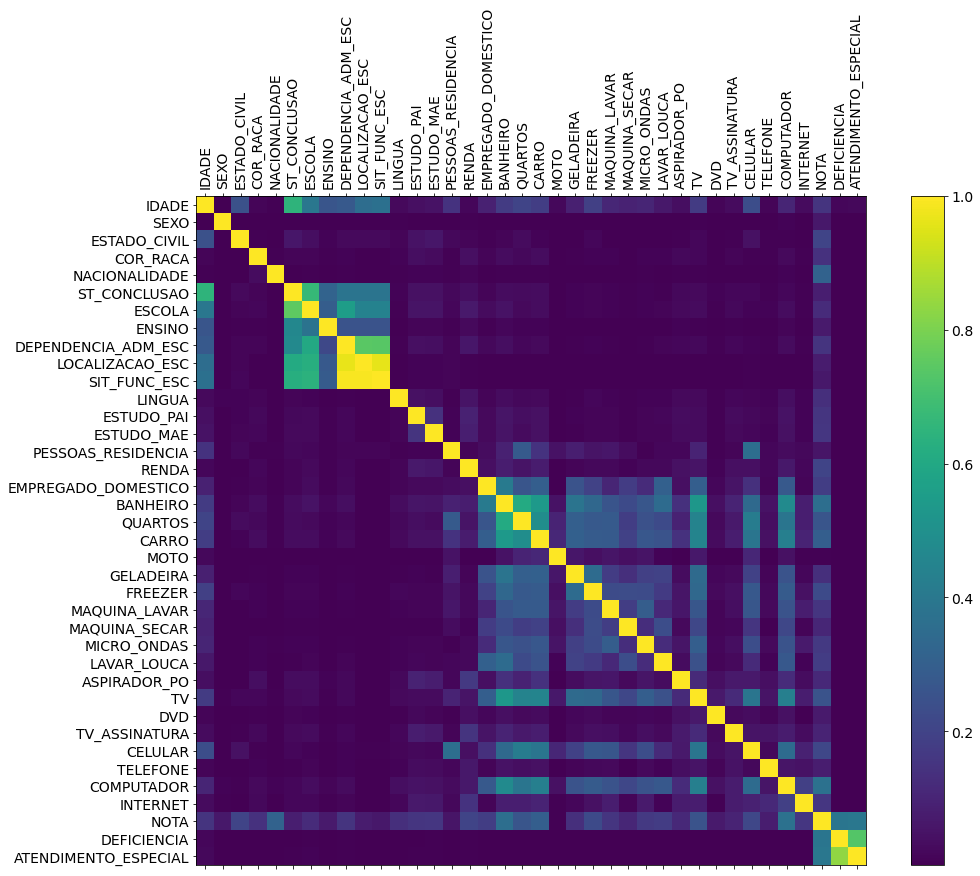

In [43]:
f = plt.figure(figsize=(16, 12))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Matriz Correlação', fontsize=16);